In [1]:
%matplotlib inline

# Example plot for LFPy: active cell model adapted from Mainen and Sejnowski (1996)
This is an example scripts using LFPy with an active cell model adapted from
Mainen and Sejnowski, Nature 1996, for the original files, see
http://senselab.med.yale.edu/modeldb/ShowModel.asp?model=2488

This scripts is set up to use the model, where the active conductances and
spine corrections are set in the function `active_declarations()`, and uses
the mechanisms from the .mod-files provided here.
For this example to work, run `nrnivmodl` in this folder to compile these
mechanisms (i.e. `/$PATHTONEURON/nrn/x86_64/bin/nrnivmodl`).

The active parameters are similar to the file `active_declarations_example3.py`

Here, excitatory and inhibitory neurons are distributed on different parts of
the morphology, with stochastic spike times produced by the
LFPy.inputgenerators.stationary_gamma() function.


Copyright (C) 2017 Computational Neuroscience Group, NMBU.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

In [2]:
# importing some modules, including LFPy
import LFPy
import os
from os.path import join
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import zipfile
import ssl
from warnings import warn
import numpy as np
import scipy.stats
import neuron
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size' : 12,
                     'figure.facecolor' : '1',
                     'figure.subplot.wspace' : 0.5,
                     'figure.subplot.hspace' : 0.5})

#seed for random generation
np.random.seed(1234)

## Fetch Mainen&Sejnowski 1996 model files

In [3]:
if not os.path.isfile(join('cells', 'cells', 'j4a.hoc')):
    # get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=2488&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('patdemo.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    # unzip:
    myzip = zipfile.ZipFile('patdemo.zip', 'r')
    myzip.extractall('.')
    myzip.close()

# compile mod files every time, because of incompatibility with Hay2011 files:
if "win32" in sys.platform:
    pth = "cells"
    warn("no autompile of NMODL (.mod) files on Windows. " 
         + "Run mknrndll from NEURON bash in the folder cells and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"/nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd cells
              nrnivmodl
              ''')
    neuron.load_mechanisms('cells')

## A couple of function declarations:

In [4]:
def active_declarations():
    '''set active conductances and correct for spines,
    see file active_declarations_example3.hoc'''
    spine_dens = 1
    spine_area = 0.83 # // um^2  -- K Harris
        
    cm_myelin = 0.04
    g_pas_node = 0.02
    
    celsius   = 37.
    
    Ek = -85.
    Ena = 60.
    
    gna_dend = 20.
    gna_node = 30000.
    gna_soma = gna_dend * 10
    
    gkv_axon = 2000.
    gkv_soma = 200.
    
    gca = .3
    gkm = .1
    gkca = 3
    
    gca_soma = gca
    gkm_soma = gkm
    gkca_soma = gkca
    
    dendritic = neuron.h.SectionList()
    for sec in neuron.h.allsec():
        if sec.name()[:4] == 'soma':
            dendritic.append(sec)
        if sec.name()[:4] == 'dend':
            dendritic.append(sec)
        if sec.name()[:4] == 'apic':
            dendritic.append(sec)
    
    def add_spines(section):
        '''add spines as a modification of the compartment area'''
        is_spiny = 1
        if section == "dend":
            print("adding spines")
            for sec in neuron.h.dendlist:
                a = 0
                for seg in sec:
                    a += neuron.h.area(seg.x)
                
                F = (sec.L*spine_area*spine_dens + a)/a
                sec.L = sec.L * F**(2./3.)
                for seg in sec:
                    seg.diam = seg.diam * F**(1./3.)
                
        neuron.h.define_shape()

    # Insert active channels
    def set_active():
        '''set the channel densities'''
        # exceptions along the axon
        for sec in neuron.h.myelin:
            sec.cm = cm_myelin
        for sec in neuron.h.node: 
            sec.g_pas = g_pas_node
            
        # na+ channels
        for sec in neuron.h.allsec():
            sec.insert('na')
        for sec in dendritic:
            sec.gbar_na = gna_dend            
        for sec in neuron.h.myelin:
            sec.gbar_na = gna_dend
        for sec in neuron.h.hill:
            sec.gbar_na = gna_node
        for sec in neuron.h.iseg:
            sec.gbar_na = gna_node
        for sec in neuron.h.node:
            sec.gbar_na = gna_node
                    
        # kv delayed rectifier channels
        neuron.h.iseg.insert('kv')
        neuron.h.iseg.gbar_kv = gkv_axon
        neuron.h.hill.insert('kv')
        neuron.h.hill.gbar_kv = gkv_axon
        for sec in neuron.h.soma:
            sec.insert('kv')
            sec.gbar_kv = gkv_soma
        
        # dendritic channels
        for sec in dendritic:
            sec.insert('km')
            sec.gbar_km  = gkm
            sec.insert('kca')
            sec.gbar_kca = gkca
            sec.insert('ca')
            sec.gbar_ca = gca
            sec.insert('cad')
        
        # somatic channels
        for sec in neuron.h.soma:
            sec.gbar_na = gna_soma
            sec.gbar_km = gkm_soma
            sec.gbar_kca = gkca_soma
            sec.gbar_ca = gca_soma
        
        for sec in neuron.h.allsec():
            if neuron.h.ismembrane('k_ion'):
                sec.ek = Ek
        
        for sec in neuron.h.allsec():
            if neuron.h.ismembrane('na_ion'):
                sec.ena = Ena
                neuron.h.vshift_na = -5
                
        for sec in neuron.h.allsec():
            if neuron.h.ismembrane('ca_ion'):
                sec.eca = 140
                neuron.h.ion_style("ca_ion", 0, 1, 0, 0, 0)
                neuron.h.vshift_ca = 0
        
        #set the temperature for the neuron dynamics
        neuron.h.celsius = celsius
        
        print("active ion-channels inserted.")
        
        
    #// Insert spines
    add_spines('dend')
    
    #// Insert active channels
    set_active()

In [5]:
def insert_synapses(synparams, section, n, spTimesFun, args):
    '''find n compartments to insert synapses onto'''
    idx = cell.get_rand_idx_area_norm(section=section, nidx=n)

    #Insert synapses in an iterative fashion
    for i in idx:
        synparams.update({'idx' : int(i)})

        # Some input spike train using the function call
        [spiketimes] = spTimesFun(**args)
        
        # Create synapse(s) and setting times using the Synapse class in LFPy
        s = LFPy.Synapse(cell, **synparams)
        s.set_spike_times(spiketimes)

## Parameters etc.:
Define parameters, using dictionaries. It is possible to set a few more parameters for each class or functions, but
we chose to show only the most important ones here.

In [6]:
# Define cell parameters used as input to cell-class
cellParameters = {
    'morphology' : join('morphologies', 'L5_Mainen96_wAxon_LFPy.hoc'),
    'cm' : 1.0,                 # membrane capacitance
    'Ra' : 150,                 # axial resistance
    'v_init' : -65,             # initial crossmembrane potential
    'passive' : True,           # switch on passive mechs
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65}, # passive params
    'nsegs_method' : 'lambda_f',# method for setting number of segments,
    'lambda_f' : 100,           # segments are isopotential at this frequency
    'dt' : 2**-4,               # dt of LFP and NEURON simulation.
    'tstart' : -100,          #start time, recorders start at t=0
    'tstop' : 200,           #stop time of simulation
    'custom_fun'  : [active_declarations], # will execute this function
    'custom_fun_args' : [{}],
}

# Synaptic parameters taken from Hendrickson et al 2011
# Excitatory synapse parameters:
synapseParameters_AMPA = {
    'e' : 0,                    #reversal potential
    'syntype' : 'Exp2Syn',      #conductance based exponential synapse
    'tau1' : 1.,                #Time constant, rise
    'tau2' : 3.,                #Time constant, decay
    'weight' : 0.005,           #Synaptic weight
    'record_current' : True,    #record synaptic currents
}
# Excitatory synapse parameters
synapseParameters_NMDA = {         
    'e' : 0,
    'syntype' : 'Exp2Syn',
    'tau1' : 10.,
    'tau2' : 30.,
    'weight' : 0.005,
    'record_current' : True,
}
# Inhibitory synapse parameters
synapseParameters_GABA_A = {         
    'e' : -80,
    'syntype' : 'Exp2Syn',
    'tau1' : 1.,
    'tau2' : 12.,
    'weight' : 0.005,
    'record_current' : True
}
# where to insert, how many, and which input statistics
insert_synapses_AMPA_args = {
    'section' : 'apic',
    'n' : 100,
    'spTimesFun' : LFPy.inputgenerators.get_activation_times_from_distribution,
    'args' : dict(n=1, tstart=0, tstop=cellParameters['tstop'],
                  distribution=scipy.stats.gamma,
                  rvs_args=dict(a=0.5, loc=0., scale=40)
                  )
}
insert_synapses_NMDA_args = {
    'section' : ['dend', 'apic'],
    'n' : 15,
    'spTimesFun' : LFPy.inputgenerators.get_activation_times_from_distribution,
    'args' : dict(n=1, tstart=0, tstop=cellParameters['tstop'],
                  distribution=scipy.stats.gamma,
                  rvs_args=dict(a=2, loc=0, scale=50)
                  )
}
insert_synapses_GABA_A_args = {
    'section' : 'dend',
    'n' : 100,
    'spTimesFun' : LFPy.inputgenerators.get_activation_times_from_distribution,
    'args' : dict(n=1, tstart=0, tstop=cellParameters['tstop'],
                  distribution=scipy.stats.gamma,
                  rvs_args=dict(a=0.5, loc=0., scale=40)
                  )
}

# Define electrode geometry corresponding to a laminar electrode, where contact
# points have a radius r, surface normal vectors N, and LFP calculated as the
# average LFP in n random points on each contact:
N = np.empty((16, 3))
for i in range(N.shape[0]): N[i,] = [1, 0, 0] #normal unit vec. to contacts
# put parameters in dictionary
electrodeParameters = {
    'sigma' : 0.3,              # Extracellular potential
    'x' : np.zeros(16) + 25,      # x,y,z-coordinates of electrode contacts
    'y' : np.zeros(16),
    'z' : np.linspace(-500, 1000, 16),
    'n' : 20,
    'r' : 10,
    'N' : N,
}

# Parameters for the cell.simulate() call, recording membrane- and syn.-currents
simulationParameters = {
    'rec_imem' : True,  # Record Membrane currents during simulation
}

In [7]:
## Main simulation procedure:

In [8]:
# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.Cell(**cellParameters)

# Insert synapses using the function defined earlier
insert_synapses(synapseParameters_AMPA, **insert_synapses_AMPA_args)
insert_synapses(synapseParameters_NMDA, **insert_synapses_NMDA_args)
insert_synapses(synapseParameters_GABA_A, **insert_synapses_GABA_A_args)

# perform NEURON simulation, results saved as attributes in the cell instance
cell.simulate(**simulationParameters)

# Initialize electrode geometry, then calculate the LFP, using the
# LFPy.RecExtElectrode class. Note that now cell is given as input to electrode
# and created after the NEURON simulations are finished
electrode = LFPy.RecExtElectrode(cell, **electrodeParameters)
electrode.calc_lfp()

adding spines
active ion-channels inserted.


In [9]:
## plotting some variables and geometry

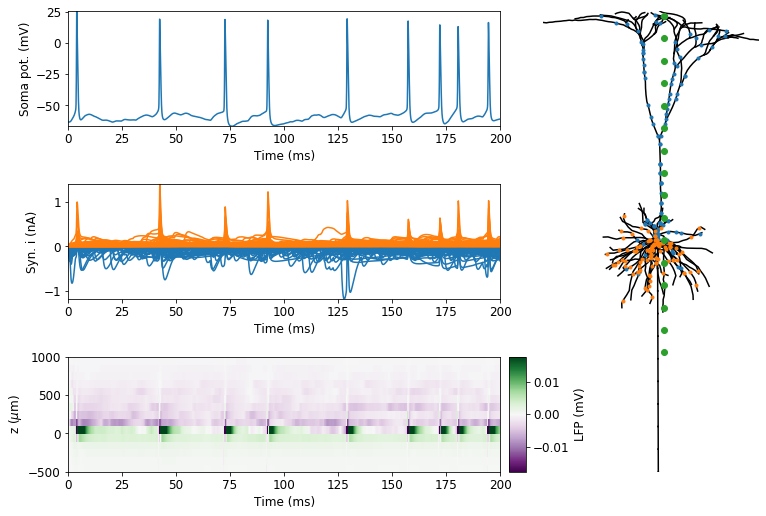

In [10]:
from example_suppl import plot_ex3
fig = plot_ex3(cell, electrode)
# Optional save
# fig.savefig('LFPy-example-7.pdf', dpi=300)